In [14]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt #for visualizations
import seaborn as sns #for visualizations
import pickle
import datetime, os

from datetime import datetime 
import nltk
from nltk.corpus import stopwords # to remove the stopwrods
from nltk.tokenize import word_tokenize #for tokenization
from nltk.stem import WordNetLemmatizer # for lemmitization

from sklearn.model_selection import train_test_split #to divide the corpus in train and test splits 
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score #For analysis

# For CNN
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Conv1D, MaxPooling1D, Dropout, Activation
from tensorflow.keras.regularizers import l2

In [3]:
#https://www.kaggle.com/rodolfoluna/fake-news-detector
#https://12ft.io/proxy?q=http://towardsdatascience.com/text-classification-in-python-dd95d264c802

In [4]:
# Data is provided in two datasets, so we need to combine them

fake_news = pd.read_csv('./Data/Fake.csv')
fake_news['Fake'] = 1

# Load real news
real_news = pd.read_csv('./Data/True.csv')
real_news['Fake'] = 0

# Join the two dataframes
news = pd.concat([fake_news, real_news])

In [5]:
news.head()

,title,text,subject,date,Fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [6]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   Fake     44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [7]:
news.describe()

,Fake
count,44898.000000
mean,0.522985
std,0.499477
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [8]:
news.isna().sum()

title      0
text       0
subject    0
date       0
Fake       0
dtype: int64

# Visualise the data

Count of fake: 
1    23481
0    21417
Name: Fake, dtype: int64


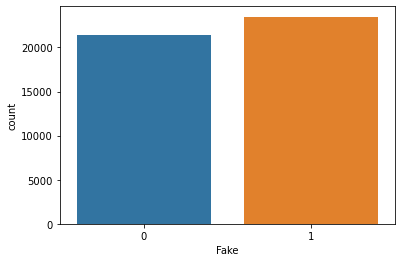

In [9]:
sns.countplot(x='Fake', data=news)
print("Count of fake: \n{}".format(news['Fake'].value_counts()))

In [10]:
average_lengths_true = []
average_lengths_false = []
count = 0
for true_article in real_news['text']:
    average_lengths_true.append(len(true_article))

for fake_article in fake_news['text']:
    average_lengths_false.append(len(fake_article))

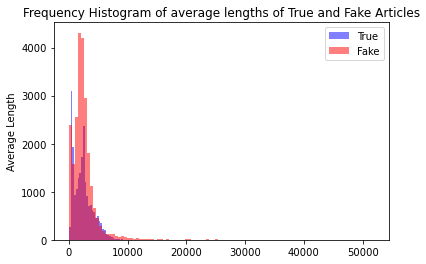

In [11]:
kwargs = dict(alpha=0.5, bins=100)
plt.hist(average_lengths_true, **kwargs, color='b', label='True')
plt.hist(average_lengths_false, **kwargs, color='r', label='Fake')
plt.gca().set(title='Frequency Histogram of average lengths of True and Fake Articles', ylabel='Average Length')
plt.legend();

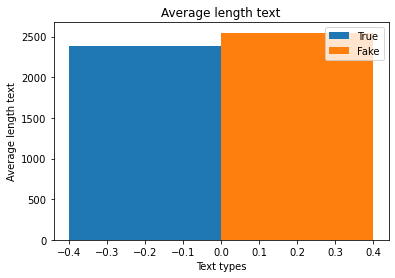

In [12]:
from statistics import mean

average_true_article_len = mean(average_lengths_true)
average_fake_article_len = mean(average_lengths_false)


X_axis = np.arange(1)
plt.bar(X_axis - 0.2, average_true_article_len, 0.4, label = 'True')
plt.bar(X_axis + 0.2, average_fake_article_len, 0.4, label = 'Fake')
  

plt.xlabel("Text types")
plt.ylabel("Average length text")
plt.title("Average length text")
plt.legend()
plt.show()


# Feature Engineering

In [13]:
news['date'] = pd.to_datetime(news['date'], errors='coerce')
news['Year'] = news['date'].dt.year
news['Month'] = news['date'].dt.month

news.head()

,title,text,subject,date,Fake,Year,Month
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,1,2017.0,12.0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,1,2017.0,12.0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,1,2017.0,12.0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,1,2017.0,12.0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,1,2017.0,12.0


<AxesSubplot:xlabel='Year', ylabel='count'>

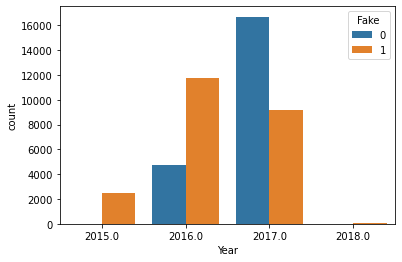

In [14]:
# Check the impact of Year on the target variable
sns.countplot(x='Year', data=news, hue='Fake')

<AxesSubplot:xlabel='Month', ylabel='count'>

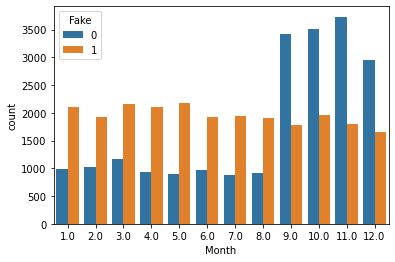

In [15]:
# Check the impact of Month on the target variable
sns.countplot(x='Month', data=news, hue='Fake')

In [16]:
#We want all information of an article, which would be the title, text and subject
news['Article'] = news['title']+""+news['text']+""+['subject']

In [17]:
final_news = news[['Article', 'Fake']]

# Prepare Data

## Lower and remove punctutation

In [18]:
final_news['Article'] = final_news['Article'].apply(lambda x: x.lower())

E:\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
final_news.head()

,Article,Fake
0,donald trump sends out embarrassing new year’...,1
1,drunk bragging trump staffer started russian ...,1
2,sheriff david clarke becomes an internet joke...,1
3,trump is so obsessed he even has obama’s name...,1
4,pope francis just called out donald trump dur...,1


In [20]:
# remove punctutations
def remove_punct(input_string):
    split_article = [char for char in input_string if char not in string.punctuation]
    clean_article = ''.join(split_article)
    return clean_article

In [21]:
final_news['Article'] = final_news['Article'].apply(remove_punct)

E:\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
final_news['Article'].head() 

0     donald trump sends out embarrassing new year’...
1     drunk bragging trump staffer started russian ...
2     sheriff david clarke becomes an internet joke...
3     trump is so obsessed he even has obama’s name...
4     pope francis just called out donald trump dur...
Name: Article, dtype: object

# Tokenize

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Simon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
for article in final_news['Article']:
    #word_tokenize is a function from the nltk.tokenize package
    tokenized_article = word_tokenize(article)

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Simon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Stopwords

In [26]:
stopWords = stopwords.words('english')
filtered_document = []
filtered_article = []
#final_news['Article'].apply(lambda x: [item for item in tqdm(x) if item not in stopWords])

for sentence in final_news['Article']:
    #Having taken a sentence, remove the stopwords of that sentence
    for word in sentence:
        if word not in stopWords:
            #save the tokenized, stopword-less article in a list
            filtered_article.append(word)
    sentence = filtered_article
    
    #Add the filtered sentence to the overal documents list
    #filtered_document.append(sentence)
    
    #reset the sentence list so that we do not accidently save multiple articles as one article
    #filtererd_article = []
    

In [27]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Simon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Lemmatization

In [28]:
# Lemmatization function

lemmatizer = WordNetLemmatizer()

def lemmatize_text(article):
    #lemmatize each word in the article
    return [lemmatizer.lemmatize(word) for word in article]  
    

In [29]:
# call the lemmatization function on each sentence in the corpus
#Cleaned_articles = []

for article in final_news['Article']:
    #this might go wrong --> the input is a list of tokenized words, so this might return individual lemmatized words
    # Might also go wrong by not being able to lemmatize a text --> would need to go one layer deeper
    lemmatizing_sentences = lemmatize_text(article)
    ##Cleaned_articles.append(lemmatizing_sentences)

In [30]:
final_news.head()

,Article,Fake
0,donald trump sends out embarrassing new year’...,1
1,drunk bragging trump staffer started russian ...,1
2,sheriff david clarke becomes an internet joke...,1
3,trump is so obsessed he even has obama’s name...,1
4,pope francis just called out donald trump dur...,1


In [31]:
for article in final_news["Article"]:
    article = final_news["Article"].array

In [32]:
# Pad the articles to make them all the same length
longest_article_length = len(max(final_news["Article"], key=len))


for article in final_news["Article"]:
    article = article.ljust(longest_article_length) 

In [33]:
X = final_news["Article"]
Y = final_news["Fake"]

In [34]:
from collections import Counter
wordCount = Counter(check for article in X for check in article.split())

In [35]:
wordCount;

In [36]:
atleast_1_000_occurences = {x: count for x, count in wordCount.items() if count >= 1_000}
atleast_10_000_occurences = {x: count for x, count in wordCount.items() if count >= 10_000}

# Build the model

### Bag of words model

Bag of words uses the occurences of words in the corpus. This is a great baseline and a surprisingly effective model for its simplicity

In [37]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Occurence_vector = TfidfVectorizer()
fitted_X = Occurence_vector.fit_transform(X)
Occurence_vector.get_feature_names_out() 


array(['00', '000', '0000', ..., 'émigré', 'état', 'žižek'], dtype=object)

In [38]:
# open a file, where you ant to store the data
file = open('./Data/fitted_X', 'wb')

# dump information to that file
pickle.dump(fitted_X, file)

# close the file
file.close()

In [39]:
# open a file, where you ant to store the data
file = open('./Data/X', 'wb')

# dump information to that file
pickle.dump(X, file)

# close the file
file.close()

# open a file, where you ant to store the data
file = open('./Data/Y', 'wb')

# dump information to that file
pickle.dump(Y, file)

# close the file
file.close()

In [40]:
# open a file, where you ant to store the data
file = open('./Data/atleast_1_000_occurences', 'wb')

# dump information to that file
pickle.dump(atleast_1_000_occurences, file)

# close the file
file.close()

# open a file, where you ant to store the data
file = open('./Data/atleast_10_000_occurences', 'wb')

# dump information to that file
pickle.dump(atleast_10_000_occurences, file)

# close the file
file.close()




In [2]:
fitted_X = pickle.load( open( "./Data/fitted_X", "rb" ) )
X = pickle.load( open( "./Data/X", "rb" ) )
Y = pickle.load( open( "./Data/Y", "rb" ) )



In [42]:
fitted_X.shape

(44898, 248247)

In [43]:
X.shape

(44898,)

In [44]:
Y.shape

(44898,)

In [3]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state= 1, shuffle=True)

# SVM

In [46]:
#SVM model

from sklearn import svm
svm_model = svm.SVC()
svm_model.fit(x_train, y_train)


ValueError: could not convert string to float: 'flashback 2015 antigun obsessed white house gives tips on how to talk about “gun control” at thanksgiving videonothing says  thanksgiving  or  family  like a room full of brain washed liberals sitting around the dinner table talking about ways to strip americans of their constitutional rights this thanksgiving the obama administration wants americans to talk about why congress won t pass more gun control   but not about obama s foreign policy failuresduring the white house press briefing press secretary josh earnest continued to press a narrative set up by gun control activists in response to the terrorist attacks in paris as people sitting around the thanksgiving table talking about these issues as they should and i m sure they will all across the country i hope that s a question that will be raised and asked by members around the table  earnest said referring to a bill supported by democrat to ban people on the nofly list from purchasing a gunearnest attributed opposition to the bill from republicans and some democrats to  fear  of the national rifle associationbut as breitbart news gun reporter awr hawkins has noted the campaign is misguided as the nofly list is imprecise a law based on that list could would block innocent individuals from exercising their second amendment right to purchase firearmsvia breitbart newsand for those who choose to take the proamerican side of the second amendment argument here s a little video you might want to share with your guestssubject'

In [ ]:
svm_prediction = svm_model.predict(x_test)


In [ ]:
np.mean(svm_prediction == y_test)

0.9928730512249443

# LR

In [ ]:
#Logistic regression model

In [ ]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression(random_state=1).fit(x_train, y_train)
LR_prediction = LR_model.predict(x_test)


In [ ]:
np.mean(LR_prediction == y_test)

0.9874164810690423

# CNN

For the CNN, various architectures can be used. After looking around online, we build upon the architecture described in section 2 of [Best practices document classification deep learning](https://machinelearningmastery.com/best-practices-document-classification-deep-learning/)

In [4]:
embeddings_dictionary = {}

##embedding_test = {}
#count = 0

f = open("./Data/glove.6b.100d.txt", encoding="utf8")


for line in f:
    #if count <= 5:
    #    print(f"LINE: {line}")

    values = line.split()
    #if count <= 5:
    #    print(f"values: {values}")

    word = values[0]
    #if count <= 5:
    #    print(f"WORD: {word}")

    coefficients = np.asarray(values[1:], dtype='float32')
    #if count <= 5:
    #    print(f"coefficients: {coefficients}")
    #    embedding_test[word] = coefficients

    embeddings_dictionary[word] = coefficients

    #count += 1
f.close()

# Some sources regarding CNN

1. [Text Classification using CNN](https://www.kaggle.com/au1206/text-classification-using-cnn)
2. [Word Embeddings for movie review sentiment](https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/)
3. [Text Classification using CNN](https://12ft.io/proxy?q=http://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9)

14.52

In [5]:
# set parameters:
vocab_size = 1000
maxlen_article = 1000
batch_size = 32
embeddings_dim = 10
filters = 128
kernels = 3
hidden_dims = 250
epochs = 25

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(x_train)

x_train_matrix = tokenizer.texts_to_matrix(x_train)
x_test_matrix = tokenizer.texts_to_matrix(x_test)

x_train_matrix = pad_sequences(x_train_matrix, maxlen= maxlen_article)
x_test_matrix = pad_sequences(x_test_matrix, maxlen= maxlen_article)

In [6]:
embedding_matrix = np.zeros((vocab_size, 100))

for word, index in tokenizer.word_index.items():
    
    if index > vocab_size-1:
        break

    else:
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [30]:
model = Sequential()


In [31]:
model.add(Embedding(vocab_size, 100, input_length = maxlen_article, weights=[embedding_matrix], trainable=False))
model.add(Conv1D(filters, kernels, padding='same', activation='relu'))
model.add(MaxPooling1D(padding='same'))
model.add(Flatten())
model.add(Dense(10, activation='relu'))

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1000, 100)         100000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1000, 128)         38528     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 500, 128)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                640010    
Total params: 778,538
Trainable params: 678,538
Non-trainable params: 100,000
_________________________________________________________________


In [ ]:
model.fit(x_train_matrix, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

In [53]:
x_train_matrix.shape

(35918, 1000)

In [13]:
x_train_matrix.shape

(35918, 1000)

In [55]:
y_train.shape

(35918,)

In [56]:
y_test.shape

(8980,)

In [31]:
# make the max word length to be constant
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 1000
# the percentage of train test split to be applied
VALIDATION_SPLIT = 0.20
# the dimension of vectors to be used
EMBEDDING_DIM = 100
# filter sizes of the different conv layers 
filter_sizes = [3,4,5]
num_filters = 512
embedding_dim = 100
# dropout probability
drop = 0.5
batch_size = 512
epochs = 10

In [8]:
tokenizer  = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(X)
sequences =  tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data, Y, test_size= 0.2, random_state= 1, shuffle=True)

In [10]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [32]:

# define model
model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         27669000  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 993, 32)           25632     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 496, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 15872)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                158730    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 27,853,373
Trainable params: 184,373
Non-trainable params: 27,669,000
____________________________________

In [33]:
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# We can visualize the model results with tensorflows tensorboard
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


# fit network
model.fit(x_train, y_train, epochs=10, verbose=1, validation_data=(x_test, y_test), callbacks=[tensorboard_callback, earlystop])

Epoch 1/10
1123/1123 [==============================] - 39s 35ms/step - loss: 0.4481 - accuracy: 0.8942 - val_loss: 0.2905 - val_accuracy: 0.9528
Epoch 2/10
1123/1123 [==============================] - 39s 35ms/step - loss: 0.1301 - accuracy: 0.9712 - val_loss: 0.0939 - val_accuracy: 0.9839
Epoch 3/10
1123/1123 [==============================] - 39s 35ms/step - loss: 0.0816 - accuracy: 0.9845 - val_loss: 0.0850 - val_accuracy: 0.9843
Epoch 4/10
1123/1123 [==============================] - 40s 35ms/step - loss: 0.0674 - accuracy: 0.9875 - val_loss: 0.0655 - val_accuracy: 0.9873
Epoch 5/10
1123/1123 [==============================] - 39s 35ms/step - loss: 0.0619 - accuracy: 0.9885 - val_loss: 0.1795 - val_accuracy: 0.9512
Epoch 6/10
1123/1123 [==============================] - 39s 35ms/step - loss: 0.0571 - accuracy: 0.9905 - val_loss: 0.0684 - val_accuracy: 0.9878
Epoch 7/10
1123/1123 [==============================] - 40s 35ms/step - loss: 0.0553 - accuracy: 0.9910 - val_loss: 0.0691 -

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs


%tensorboard --logdir {logs_base_dir}  --host localhost

In [39]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir {logs_base_dir} (started 0:16:28 ago; pid 23488)
  - port 6006: logdir logs (started 0:26:32 ago; pid 8856)


In [41]:
notebook.display(port=6006, height=1000) 

Selecting TensorBoard with logdir {logs_base_dir} (started 0:16:36 ago; port 6006, pid 23488).
